In [1]:
!pip install -U datasets huggingface_hub transformers[torch] evaluate peft bitsandbytes trl --quiet

In [3]:
from transformers import TrainingArguments, Trainer
import torch

2024-05-26 11:13:36.766350: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-26 11:13:36.766453: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-26 11:13:36.905676: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
from datasets import load_dataset

dataset = load_dataset("nyu-mll/multi_nli")

Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating validation_matched split:   0%|          | 0/9815 [00:00<?, ? examples/s]

Generating validation_mismatched split:   0%|          | 0/9832 [00:00<?, ? examples/s]

In [6]:
from transformers import BitsAndBytesConfig

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=False,
)

In [7]:
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers import AutoTokenizer, AutoModelForCausalLM, LlamaModel, LlamaPreTrainedModel
from torch import nn

class LlamaWithDense(LlamaPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        
        self.num_labels = 3
        self.model = LlamaModel(config)
        self.classifier = nn.Linear(config.hidden_size, self.num_labels, bias=True)
        
        self.post_init()
        
    def forward(self, input_ids = None,
        attention_mask = None,
        position_ids = None,
        past_key_values = None,
        inputs_embeds = None,
        labels = None,
        use_cache = None,
        output_attentions = None,
        output_hidden_states = None,
        return_dict = None,):
        
        transformer_outputs = self.model(
            input_ids,
            attention_mask=attention_mask,
            position_ids=position_ids,
        )
        
        hidden_states = transformer_outputs[0]
        logits = self.classifier(hidden_states)
        
        batch_size = input_ids.shape[0]
        sequence_lengths = torch.eq(input_ids, self.config.pad_token_id).int().argmax(-1) - 1
        sequence_lengths = sequence_lengths % input_ids.shape[-1]
        sequence_lengths = sequence_lengths.to(logits.device)        
        pooled_logits = logits[torch.arange(batch_size, device=logits.device), sequence_lengths]
        
        loss = None
        if labels is not None:
            labels = labels.to(logits.device)
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(pooled_logits.view(-1, self.num_labels), labels.view(-1))

        return SequenceClassifierOutput(
            loss=loss,
            logits=pooled_logits,
            hidden_states=transformer_outputs.hidden_states,
            attentions=transformer_outputs.attentions,
        )

In [8]:
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Meta-Llama-3-8B", padding_side='left')
tokenizer.pad_token = tokenizer.eos_token
tokenizer.add_eos_token = True

model = LlamaWithDense.from_pretrained(
    "meta-llama/Meta-Llama-3-8B",
    quantization_config=bnb_config,
    device_map="auto",
)
model.config.pad_token_id = tokenizer.eos_token_id

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of LlamaWithDense were not initialized from the model checkpoint at meta-llama/Meta-Llama-3-8B and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
'''
import gc

del model
gc.collect()
torch.cuda.empty_cache()
'''

'\nimport gc\n\ndel model\ngc.collect()\ntorch.cuda.empty_cache()\n'

In [10]:
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

model = prepare_model_for_kbit_training(model)

In [11]:
import evaluate

accuracy = evaluate.load("accuracy")

In [12]:
def tokenize_func(examples):
    return tokenizer(examples['prompt'], truncation=True, padding=True, max_length=512)

In [13]:
train_len = len(dataset['train'])

In [14]:
dataset['train'] = dataset['train'].filter(lambda example, idx: idx < train_len * 0.1, with_indices=True)

Filter:   0%|          | 0/392702 [00:00<?, ? examples/s]

In [15]:
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [16]:
def generate_instructions(example):
    example['prompt'] = f'''Textual Entailment Task:
- If the *premise* logically implies the negation or opposite of the *hypothesis* (i.e., they are contradicting), then the *Sentence Label* should be equal to 2.
- If the *premise* does not provide enough information to determine if the *hypothesis* is true or false (i.e., they are neutral), then the *Sentence Label* should be equal to 1.
- If the *premise* logically implies or entails the *hypothesis*, then the *Sentence Label* should be equal to 0.
- The sentence label should end with 0, 1, or 2. (e.g. Sentence label = 1)
------------------
Premise: "{example['premise']}"
Hypothesis: "{example['hypothesis']}"
Sentence label = '''

    return example

dataset = dataset.map(generate_instructions)
dataset = dataset.map(tokenize_func)

Map:   0%|          | 0/39271 [00:00<?, ? examples/s]

Map:   0%|          | 0/9815 [00:00<?, ? examples/s]

Map:   0%|          | 0/9832 [00:00<?, ? examples/s]

Map:   0%|          | 0/39271 [00:00<?, ? examples/s]

Map:   0%|          | 0/9815 [00:00<?, ? examples/s]

Map:   0%|          | 0/9832 [00:00<?, ? examples/s]

In [17]:
model

LlamaWithDense(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): Llam

In [18]:
peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.1,
    r=64,
    bias="none",
    target_modules="all-linear"
)

In [19]:
model = get_peft_model(model, peft_config)

In [20]:
model.config.use_cache = False

In [21]:
from transformers import DataCollatorWithPadding

In [22]:
training_args = TrainingArguments(
    output_dir = './result',
    save_steps=0.9,
    learning_rate=2e-4,
    num_train_epochs=1,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    warmup_steps=0.1,
    weight_decay=0.01,
    report_to='none',
    overwrite_output_dir=True,
    fp16=False,
    optim="paged_adamw_8bit",
    max_steps=1000,
    logging_steps=0.25,
)


trainer = Trainer(
    model=model,
    train_dataset=dataset['train'],
    args=training_args,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
)

max_steps is given, it will override any value given in num_train_epochs


In [23]:
model

PeftModel(
  (base_model): LoraModel(
    (model): LlamaWithDense(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 4096)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=64, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=64, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_featur

In [24]:
model.print_trainable_parameters()

trainable params: 168,034,496 || all params: 7,672,971,459 || trainable%: 2.1900


In [25]:
trainer.train()

/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss
250,0.890600
500,0.669800
750,0.534300
1000,0.377800


/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


TrainOutput(global_step=1000, training_loss=0.6181046295166016, metrics={'train_runtime': 6656.025, 'train_samples_per_second': 0.601, 'train_steps_per_second': 0.15, 'total_flos': 3.865195066086425e+16, 'train_loss': 0.6181046295166016, 'epoch': 0.10185373803218578})

In [26]:
trainer.model.save_pretrained("./qlora_adapter")

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [27]:
def predict(examples):
    tokenized = tokenizer(examples, return_tensors='pt', truncation=True, padding=True, max_length=512).to(device)
    outputs = trainer.model(**tokenized)
    logits = outputs.logits
    
    return torch.softmax(logits, dim=-1).argmax(dim=-1)

In [28]:
from tqdm import tqdm

predictions = []
references = []
trainer.model.eval()

dataset_len = round(len(dataset['validation_matched']) * 1.0)

with torch.no_grad():
    for i in tqdm(range(0, dataset_len, 8)):
        examples = dataset['validation_matched'][i + 0:i + 8]
        prediction = predict(examples['prompt']).cpu().tolist()

        reference = examples['label']

        predictions += prediction
        references += reference

100%|██████████| 1227/1227 [1:20:17<00:00,  3.93s/it]


In [29]:
accuracy.compute(predictions=predictions, references=references)

{'accuracy': 0.8829342842587876}

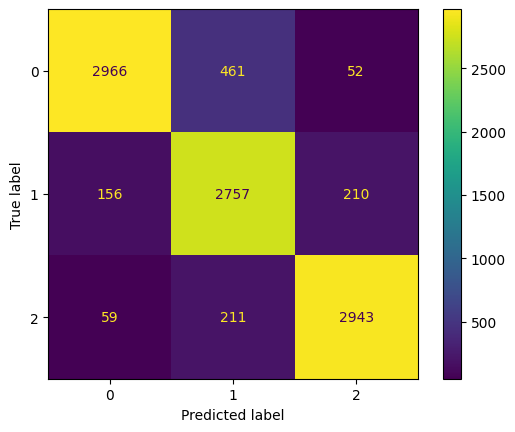

In [30]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

matrix = confusion_matrix(y_true=references, y_pred=predictions, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot()
plt.show()

In [ ]:
predictions = []
references = []
trainer.model.eval()

dataset_len = round(len(dataset['validation_mismatched']) * 1.0)

with torch.no_grad():
    for i in tqdm(range(0, dataset_len, 8)):
        examples = dataset['validation_mismatched'][i + 0:i + 8]
        prediction = predict(examples['prompt']).cpu().tolist()

        reference = examples['label']

        predictions += prediction
        references += reference

 16%|█▌        | 199/1229 [12:51<1:13:57,  4.31s/it]

In [35]:
accuracy.compute(predictions=predictions, references=references)

{'accuracy': 0.8891375101708706}

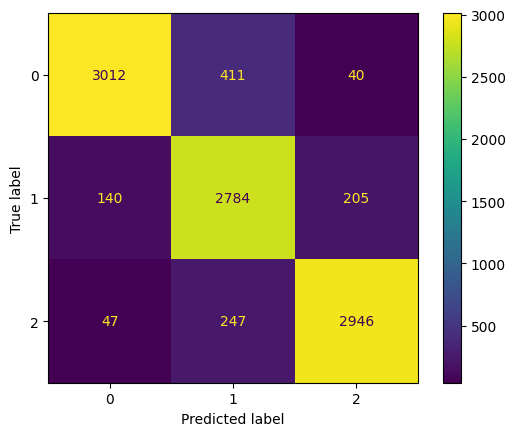

In [36]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

matrix = confusion_matrix(y_true=references, y_pred=predictions, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot()
plt.show()